This notebook runs the comparison between different pre-processing procedures before running multivariate analyses. We rely on two hypothesis-free metrics that are considered proxies of noise measures in multivariate fMRI analyses:  
1) Discriminabiliy
2) Stability

# Load packages and Data

In [ ]:
# import packages

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import json
import pandas as pd
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump,load

project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(os.path.join(project_path,'src'))
from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import compute_rdm,lower_tri,upper_tri
from zpyhelper.MVPA.preprocessors import scale_feature, split_data

import scipy

import plotly.graph_objects as go

In [13]:
# load data
project_path = r'E:\pirate_fmri\Analysis'
study_scripts   = os.path.join(project_path,'scripts','Exp1_fmri')
outputdata_dir  = os.path.join(project_path,'data','Exp1_fmri')
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    cohort1ids = [x for x in pirate_defaults['participants']['cohort1ids'] if x in subid_list]
    cohort2ids = [x for x in pirate_defaults['participants']['cohort2ids'] if x in subid_list]
    #subid_list = deepcopy(cohort1ids)
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nongeneralizers = pirate_defaults['participants']["nongeneralizerids"]
    generalizers    = pirate_defaults['participants']["generalizerids"]

ROI_data = load(os.path.join(fmridata_dir,'ROIdata',"roi_data_4r.pkl")) 

base_rois = list(ROI_data.keys())

assert len(ROI_data[base_rois[0]]) == len(subid_list)

In [14]:
# handy functions
def split_odd_even(runX_list):
    """Split the input list into odd and even indexed elements.

    Parameters
    ----------
    runX_list : list
        A list of arrays to be split.

    Returns
    -------
    tuple
        A tuple containing the mean of odd indexed elements and the mean of even indexed elements.
    """
    X_odd = np.mean(runX_list[0::2],axis=0)
    X_even = np.mean(runX_list[1::2],axis=0)
    return X_odd, X_even


def compute_cross_rdm(runX_list,returnsym=True,neuralrdm_metric="correlation"):
    """Compute the cross-run representational dissimilarity matrix (RDM) between odd and even runs. \n
    We computed the average activity patterns across all odd runs and all even runs separately before computed neural RDM. \n
    Entry (i,j) in this RDM represent the neural dis-similarity between the stimulus i from odd run and stimulus j from even run.

    Parameters
    ----------
    runX_list : list
        A list of arrays representing the fMRI data for each run.
    returnsym : bool, optional
        Whether to return a symmetric matrix, by default True
    neuralrdm_metric : str, optional
        The metric to use for computing the RDM, by default "correlation"
    returnsym : bool, optional
        Whether to return a symmetric matrix, by default True
    neuralrdm_metric : str, optional
        The metric to use for computing the RDM, by default "correlation"

    Returns
    -------
    np.ndarray
        The computed cross RDM.
    """
    X_odd,X_even = split_odd_even(runX_list)
    cross_rdm = scipy.spatial.distance.cdist(X_odd,X_even,neuralrdm_metric)
    sym_cross_rdm = (cross_rdm+cross_rdm.T)/2
    if returnsym:
        return sym_cross_rdm
    else:
        return cross_rdm


def split_half_stability(runX_list,neuralrdm_metric="correlation"):
    """Compute the split-half reliability of the RDMs. We compute the RDMs for odd and even runs separately and then correlate them.

    Parameters
    ----------
    runX_list : list
        A list of arrays representing the fMRI data for each run.
    neuralrdm_metric : str, optional
        The metric to use for computing the RDM, by default "correlation"

    Returns
    -------
    float
        The split-half reliability coefficient.
    """
    X_odd,X_even = split_odd_even(runX_list)
    rdm_odd = compute_rdm(X_odd,neuralrdm_metric)
    rdm_even = compute_rdm(X_even,neuralrdm_metric)
    result = scipy.stats.pearsonr(lower_tri(rdm_odd)[0],lower_tri(rdm_even)[0])
    return result.statistic

def split_half_discriminability(runX_list,neuralrdm_metric="correlation"):
    """Compute the split-half discriminability of the RDMs. \n
    Firsts, we get the cross-run RDM using `compute_cross_rdm`. \n
    Then, we compare whether the same stimulus is represented more similarly in odd and even runs than different stimuli. \n
    This is done by comparing the mean of the on-diagonal entries and the mean of the off-diagonal entries in the cross-run RDM.

    Parameters
    ----------
    runX_list : list
        A list of arrays representing the fMRI data for each run.
    neuralrdm_metric : str, optional
        The metric to use for computing the RDM, by default "correlation"

    Returns
    -------
    float
        The split-half discriminability coefficient.
    """
    cross_rsm = 1-compute_cross_rdm(runX_list,returnsym=False,neuralrdm_metric=neuralrdm_metric)# similarity matrix
    sym_cross_rsm = (cross_rsm+cross_rsm.T)/2
    on_d_mean = np.diag(cross_rsm).mean()
    off_d_mean = np.concatenate([lower_tri(cross_rsm)[0],upper_tri(cross_rsm)[0]]).mean()
    #deprecated: this can also be done via correlation with a model RDM that is 0 on the diagonal and 1 elsewhere
    #Z_neural = scale_feature(sym_cross_rsm.flatten(),s_dir=2,standardize=True)
    #Z_pred = scale_feature(np.diag(np.ones(25)).flatten(),s_dir=2,standardize=True)
    #r = scipy.stats.spearmanr(Z_neural,Z_pred).statistic
    return on_d_mean-off_d_mean


In [15]:
roi_reliability_dfs = []
for roiname, alldata in ROI_data.items():
    for subid, sdata in zip(subid_list,alldata):
        rdm_dist_metrics = ["correlation","euclidean"]
        navifilter = sdata['stimdf'].taskname == "navigation"
        sdf = sdata['stimdf'][navifilter].copy()
        rX = sdata['rawX'][navifilter,:]
        pX = sdata['preprocX'][navifilter,:]
        
        for X,pname in zip([rX,pX],['raw','MVNN']):
            s_st = [split_half_stability(split_data(X,sdf.stim_session),m) for m in rdm_dist_metrics]
            s_di = [split_half_discriminability(split_data(X,sdf.stim_session),m) for m in rdm_dist_metrics] 
            reliabilities = np.array([s_st,s_di]).T
            subdf = pd.DataFrame(reliabilities,columns=rdm_dist_metrics).assign(
                subid=subid,roi=roiname,preproc=pname)
            subdf["reliability_metric"] = ["stability","discriminability"]
            roi_reliability_dfs.append(subdf)

In [16]:
roi_reliability_df = pd.concat(roi_reliability_dfs,axis=0).reset_index(drop=True)
roi_reliability_df["subgroup"] = ["nonGeneralizers" if subid in nongeneralizers else "Generalizers" for subid in roi_reliability_df["subid"]]
print(f"n_Gen = {np.unique(np.array(roi_reliability_df[roi_reliability_df['subgroup']=='Generalizers']['subid'])).size}")
print(f"n_nonGen = {np.unique(np.array(roi_reliability_df[roi_reliability_df['subgroup']=='nonGeneralizers']['subid'])).size}")
roi_reliability_df["roi"] = pd.Categorical(roi_reliability_df['roi'],
                                   categories=base_rois,
                                   ordered=True)
roi_reliability_df.head(5)

n_Gen = 41
n_nonGen = 15


,correlation,euclidean,subid,roi,preproc,reliability_metric,subgroup
0,-0.026229,-0.023611,sub001,PPC_bilateral,raw,stability,Generalizers
1,0.071315,-1.729217,sub001,PPC_bilateral,raw,discriminability,Generalizers
2,-0.036037,-0.001422,sub001,PPC_bilateral,MVNN,stability,Generalizers
3,0.071065,-0.191488,sub001,PPC_bilateral,MVNN,discriminability,Generalizers
4,0.039489,-0.000520,sub002,PPC_bilateral,raw,stability,nonGeneralizers


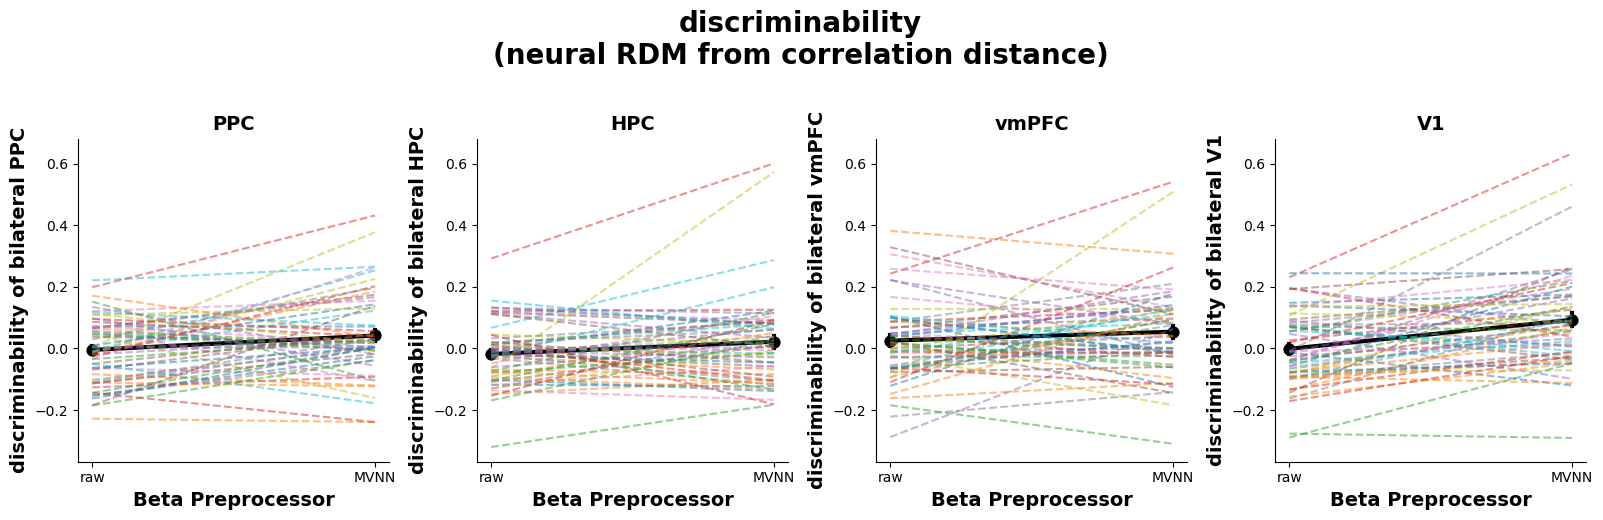

In [ ]:

curr_relia_metric = "discriminability"
roi_reliability_df_long = roi_reliability_df[roi_reliability_df.subid.isin(subid_list)].copy().reset_index(drop=True)
roi_reliability_df_long = roi_reliability_df_long[roi_reliability_df_long.reliability_metric==curr_relia_metric].copy().reset_index(drop=True)
roi_reliability_df_long['beta_preprocess'] = pd.Categorical(roi_reliability_df_long['preproc'],
                                   categories=["raw","MVNN"],
                                   ordered=True)

n_line_color = len(subid_list)
line_colors = sns.color_palette(None,n_line_color)
for dist_metric in ["correlation","euclidean"][:1]:
    split_half_gs = sns.catplot(data=roi_reliability_df_long,
                x="beta_preprocess",y=dist_metric,
                col="roi",col_wrap=4,color="k",
                units="subid",errorbar="se",
                kind="point",
                aspect = 0.8,
                sharex=False,sharey=True
                ).set_titles(template="{col_name}")
    
    yt = split_half_gs.axes.flatten()[-1].get_yticks()
    for (g_name,g_df),ax in zip(roi_reliability_df_long.groupby("roi"),split_half_gs.axes.flatten()):
        ax.set_xlabel(f"Beta Preprocessor",visible=True,fontsize=14,fontweight="bold")
        ax.set_ylabel(f"{curr_relia_metric} of bilateral {g_name.split('_')[0]}",visible=True,fontsize=14,fontweight="bold")
        
        plt.setp(ax.lines,linewidth=3)
        ax.tick_params(labelbottom=True,labelleft=True)
        for jsub,(subid,subdf) in enumerate(g_df.groupby(["subid"])):
            sns.lineplot(subdf,x="beta_preprocess",y=dist_metric,
                        **{"color":line_colors[jsub],"linestyle":"--","linewidth":1.5,"alpha":0.5},
                        ax=ax)
        
        ax.set_title(ax.get_title().split('_')[0],
                     fontsize=14,fontweight="bold")

    split_half_gs.figure.suptitle(f"{curr_relia_metric}\n(neural RDM from {dist_metric} distance)",y=1.03,fontsize=20,fontweight="bold")
    sns.move_legend(split_half_gs,loc="upper center",bbox_to_anchor=[0.5,1.01], ncol=3,
                    prop={"size":12,"weight":"bold"}, #  font properties of the legend
                    title_fontproperties = {"size":14,"weight":"bold"}) #  font properties of the legend title
    split_half_gs.figure.tight_layout()



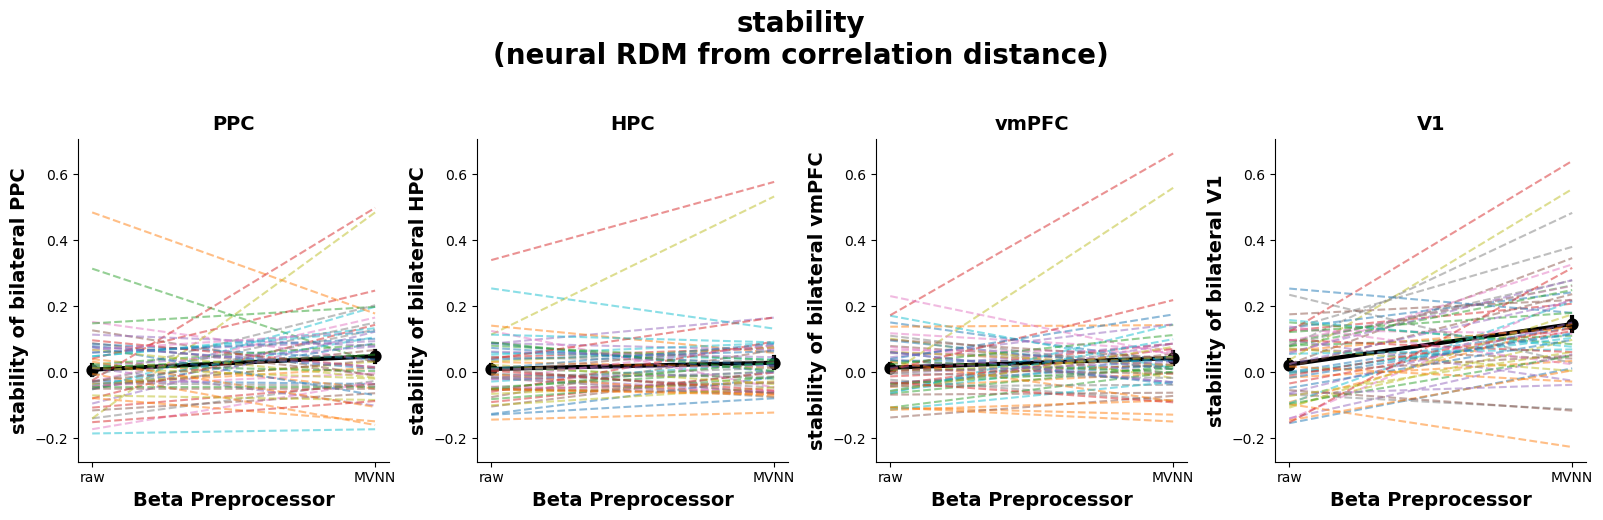

In [9]:
curr_relia_metric = "stability"
roi_reliability_df_long = roi_reliability_df[roi_reliability_df.subid.isin(subid_list)].copy().reset_index(drop=True)
roi_reliability_df_long = roi_reliability_df_long[roi_reliability_df_long.reliability_metric==curr_relia_metric].copy().reset_index(drop=True)
roi_reliability_df_long['beta_preprocess'] = pd.Categorical(roi_reliability_df_long['preproc'],
                                   categories=["raw","MVNN"],
                                   ordered=True)

n_line_color = len(subid_list)
line_colors = sns.color_palette(None,n_line_color)
for dist_metric in ["correlation","euclidean"][:1]:
    split_half_gs = sns.catplot(data=roi_reliability_df_long,
                x="beta_preprocess",y=dist_metric,
                col="roi",col_wrap=4,color="k",
                units="subid",errorbar="se",
                kind="point",
                aspect = 0.8,
                sharex=False,sharey=True
                ).set_titles(template="{col_name}")
    
    yt = split_half_gs.axes.flatten()[-1].get_yticks()
    for (g_name,g_df),ax in zip(roi_reliability_df_long.groupby("roi"),split_half_gs.axes.flatten()):
        ax.set_xlabel(f"Beta Preprocessor",visible=True,fontsize=14,fontweight="bold")
        ax.set_ylabel(f"{curr_relia_metric} of bilateral {g_name.split('_')[0]}",visible=True,fontsize=14,fontweight="bold")
        #ax.set_xticks(ticks = ax.get_xticks(),labels = ax.get_xticklabels(),  fontsize=12,fontweight="bold")
        #ax.set_yticks(ticks = yt, labels=["%.2f" % x for x in yt], fontsize=12,fontweight="bold")
        
        plt.setp(ax.lines,linewidth=3)
        ax.tick_params(labelbottom=True,labelleft=True)
        for jsub,(subid,subdf) in enumerate(g_df.groupby(["subid"])):
            sns.lineplot(subdf,x="beta_preprocess",y=dist_metric,
                        **{"color":line_colors[jsub],"linestyle":"--","linewidth":1.5,"alpha":0.5},
                        ax=ax)
        
        #wgdf = g_df.pivot(index='subid', columns='preproc', values=dist_metric)        
        #ttest_res = scipy.stats.ttest_1samp((wgdf["MVNN"] - wgdf["raw"]).to_numpy(),popmean=0,alternative="greater")
        #ax.set_title(f"{ax.get_title().split('_')[0]}\n{'T(%d)=%.3f,p=%.3f' % (ttest_res.df,ttest_res.statistic,ttest_res.pvalue)}",
        #             fontsize=14,fontweight="bold")
        ax.set_title(ax.get_title().split('_')[0],
                     fontsize=14,fontweight="bold")

    split_half_gs.figure.suptitle(f"{curr_relia_metric}\n(neural RDM from {dist_metric} distance)",y=1.03,fontsize=20,fontweight="bold")
    sns.move_legend(split_half_gs,loc="upper center",bbox_to_anchor=[0.5,1.01], ncol=3,
                    prop={"size":12,"weight":"bold"}, #  font properties of the legend
                    title_fontproperties = {"size":14,"weight":"bold"}) #  font properties of the legend title
    split_half_gs.figure.tight_layout()



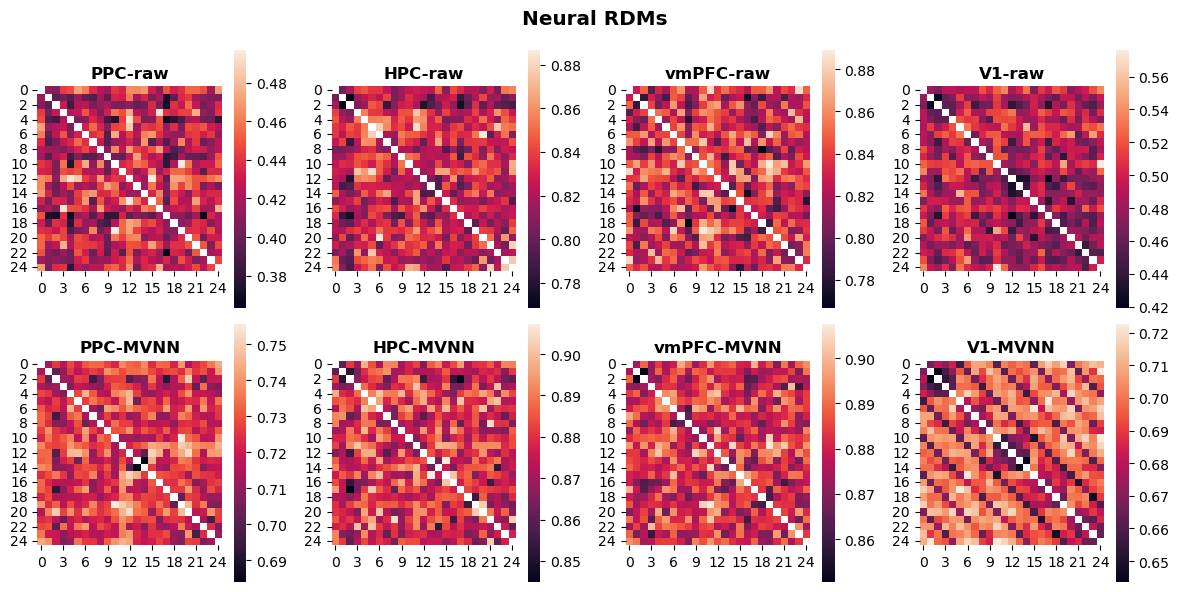

In [10]:
rdm_raw, rdm_mvnn = {},{}
for roiname, alldata in ROI_data.items():
    rdm_raw[roiname], rdm_mvnn[roiname] = [], []
    for subid, sdata in zip(subid_list,alldata):
        #if subid in cohort2ids:
            navifilter = sdata['stimdf'].taskname == "navigation"
            sdf = sdata['stimdf'][navifilter].copy()
            rX = sdata['rawX'][navifilter,:]
            pX = sdata['preprocX'][navifilter,:]

            rdm_raw[roiname].append(compute_rdm(np.mean(split_data(rX,sdf.stim_session.to_numpy()),axis=0),"correlation"))
            rdm_mvnn[roiname].append(compute_rdm(np.mean(split_data(pX,sdf.stim_session.to_numpy()),axis=0),"correlation"))
        
fig,axes = plt.subplots(2,4,figsize=(12,6))
for j,roiname in enumerate(ROI_data.keys()):
    for k,rdmlist in enumerate([rdm_raw,rdm_mvnn]):
        averdm = np.mean(rdmlist[roiname],axis=0)
        #G_averdm = np.mean(rdmlist[roiname],axis=0)
        #nG_averdm = np.mean(rdmlist[roiname],axis=0)
        np.fill_diagonal(averdm,np.nan)
        sns.heatmap(averdm,square=True,ax=axes[k,j])
        axes[k,j].set_title(f"{roiname.replace('_bilateral','')}-{['raw','MVNN'][k]}",fontweight="bold",fontsize="large")
fig.suptitle("Neural RDMs",fontweight="bold",fontsize="x-large")
fig.tight_layout()

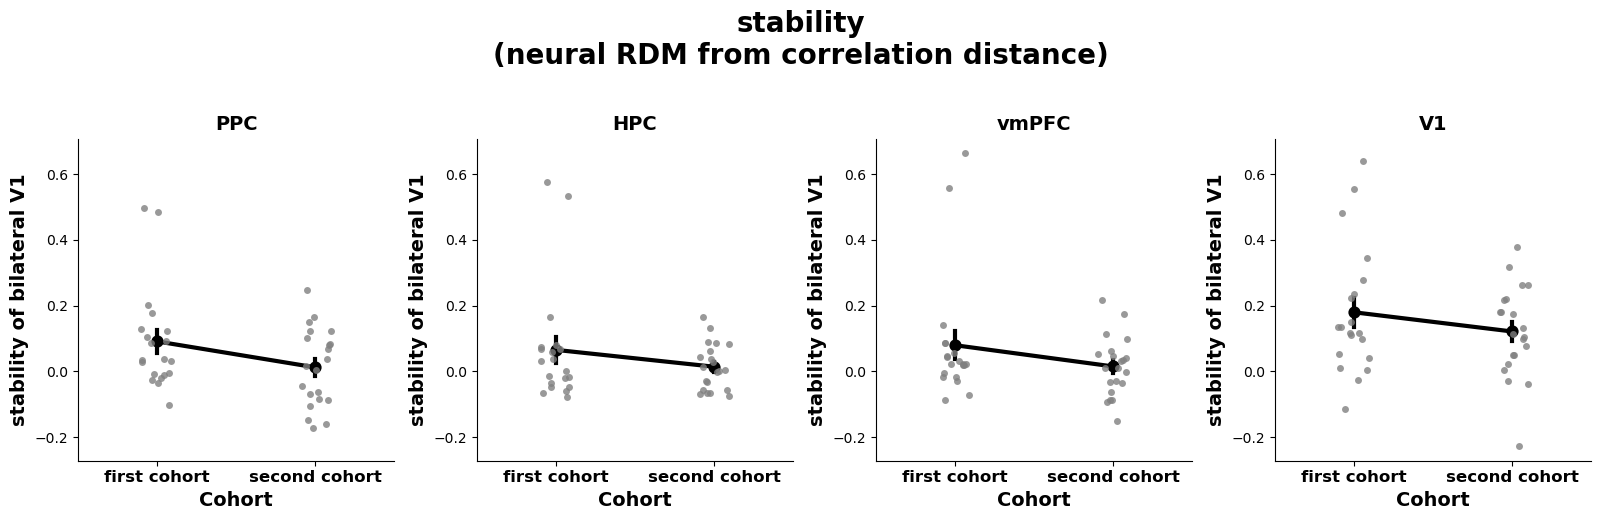

In [11]:
curr_relia_metric = "stability"
roi_reliability_df_long = roi_reliability_df[roi_reliability_df.reliability_metric==curr_relia_metric].copy().reset_index(drop=True)
roi_reliability_df_long["cohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in roi_reliability_df_long.subid]
roi_reliability_df_long["subgroup"] = ["Generalizers" if subid in generalizers else "nonGeneralizers" for subid in roi_reliability_df_long.subid]
roi_reliability_df_long['beta_preprocess'] = pd.Categorical(roi_reliability_df_long['preproc'],
                                   categories=["raw","MVNN"],
                                   ordered=True)

n_line_color = len(subid_list)
line_colors = sns.color_palette(None,n_line_color)
plot_df = roi_reliability_df_long[(roi_reliability_df_long.subid.isin(generalizers))&(roi_reliability_df_long.beta_preprocess=="MVNN")].copy()
for dist_metric in ["correlation","euclidean"][:1]:
    split_half_gs = sns.catplot(data=plot_df,
                x="cohort",y=dist_metric,
                #row="beta_preprocess",
                col="roi",
                color="k",
                units="subid",errorbar="se",
                kind="point",
                aspect = 0.8,
                sharex=False,sharey=True
                ).set_titles(template="{col_name}")
    split_half_gs.map_dataframe(sns.stripplot,data=plot_df,x="cohort",y=dist_metric,color="grey",alpha=0.8)
    yt = split_half_gs.axes.flatten()[-1].get_yticks()
    for ax in split_half_gs.axes.flatten():
        ax.set_xlabel(f"Cohort",visible=True,fontsize=14,fontweight="bold")
        ax.set_ylabel(f"{curr_relia_metric} of bilateral {g_name.split('_')[0]}",visible=True,fontsize=14,fontweight="bold")
        ax.set_xticks(ticks = ax.get_xticks(),labels = ax.get_xticklabels(),  fontsize=12,fontweight="bold")
        #ax.set_yticks(ticks = yt, labels=["%.2f" % x for x in yt], fontsize=12,fontweight="bold")
        
        plt.setp(ax.lines,linewidth=3)
        ax.tick_params(labelbottom=True,labelleft=True)
        ax.set_title(ax.get_title().replace('_bilateral',''),
                     fontsize=14,fontweight="bold")

    split_half_gs.figure.suptitle(f"{curr_relia_metric}\n(neural RDM from {dist_metric} distance)",y=1.03,fontsize=20,fontweight="bold")
    sns.move_legend(split_half_gs,loc="upper center",bbox_to_anchor=[0.5,1.01], ncol=3,
                    prop={"size":12,"weight":"bold"}, #  font properties of the legend
                    title_fontproperties = {"size":14,"weight":"bold"}) #  font properties of the legend title
    split_half_gs.figure.tight_layout()
